# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#Импорт необходим библиотек для исследования.
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#Загрузка датасетов
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head()) #просмотрим краткое содержание всех 3-х файлов.

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info()) #Продолжим изучение, сейчас посмотрим информацию по каждой локации.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [5]:
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe()) # Просмотрим статистические данные.

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
display(geo_data_0.duplicated().sum())
display(geo_data_1.duplicated().sum())
display(geo_data_2.duplicated().sum()) #Проверим, есть ли в базах данных дубликаты.

0

0

0

In [7]:
display(geo_data_0.isnull().sum())
display(geo_data_1.isnull().sum())
display(geo_data_2.isnull().sum()) #Просмотрим, есть ли пропущенные значения.

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В нашем распоряжении 3 базы данных, со следующиими признаками:  

*id* — уникальный идентификатор скважины;  
*f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);  
*product* — объём запасов в скважине (тыс. баррелей).  
В каждом файле 10 тыс. строк информации, дубликатов и пропусков нет.  

В дальнейшем исследовании и последующих стадиях проекта значение *id* не значительно, удалим его. 

In [8]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1) #Удаляем значение id.

In [9]:
print(geo_data_0.head()) #Проверим на нулевом регионе. Значение удалено.

         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647
3 -0.032172  0.139033  2.978566  168.620776
4  1.988431  0.155413  4.751769  154.036647


Построим графики, а также посмотрим, есть ли аномальные значения в датасетах.

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

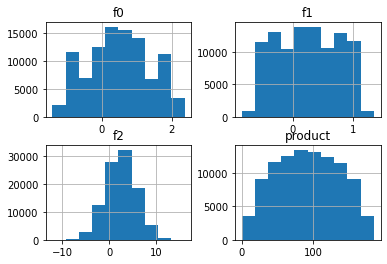

In [10]:
display(geo_data_0.hist())
plt.show

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

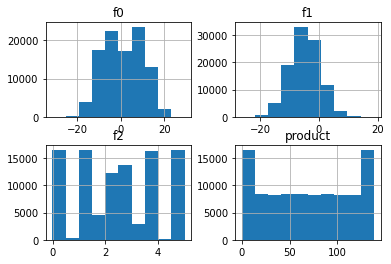

In [11]:
display(geo_data_1.hist())
plt.show

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

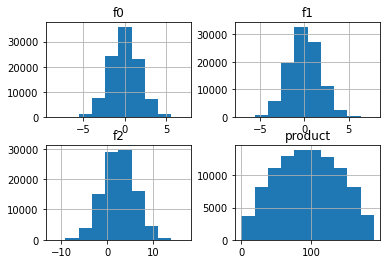

In [12]:
display(geo_data_2.hist())
plt.show

Глядя на графики можно заметить что во всех трех регионах есть нулевые значения в категории *product*, что означает пустые скважины без нефти. Поэтому в данном исследовании заполнять данные нули никакими значениями нельзя. Будем приступать к обучению с имеющимися данными.

## Обучение и проверка модели

In [13]:
#Разделяем данные на обучающие и валидационные выборки
geo_data_0_train, geo_data_0_valid = train_test_split(geo_data_0, test_size=0.25, random_state=12345)
geo_data_1_train, geo_data_1_valid = train_test_split(geo_data_1, test_size=0.25, random_state=12345)
geo_data_2_train, geo_data_2_valid = train_test_split(geo_data_2, test_size=0.25, random_state=12345)

In [14]:
features_train_0 = geo_data_0_train.drop(['product'], axis=1)
target_train_0 = geo_data_0_train['product']
features_valid_0 = geo_data_0_valid.drop(['product'], axis=1)
target_valid_0 = geo_data_0_valid['product']

features_train_1 = geo_data_1_train.drop(['product'], axis=1)
target_train_1 = geo_data_1_train['product']
features_valid_1 = geo_data_1_valid.drop(['product'], axis=1)
target_valid_1 = geo_data_1_valid['product']

features_train_2 = geo_data_2_train.drop(['product'], axis=1)
target_train_2 = geo_data_2_train['product']
features_valid_2 = geo_data_2_valid.drop(['product'], axis=1)
target_valid_2 = geo_data_2_valid['product']

In [15]:
#Проверим, прошло ли всё верно
display('Обучающая выборка нулевого региона:',features_train_0.shape)
display(target_train_0.shape)
display('Валидационная выборка нулевого региона:',features_valid_0.shape)
display(target_valid_0.shape)
display()
display('Обучающая выборка первого региона:',features_train_1.shape)
display(target_train_1.shape)
display('Валидационная выборка первого региона:',features_valid_1.shape)
display(target_valid_1.shape)
display()
display('Обучающая выборка второго региона:',features_train_2.shape)
display(target_train_2.shape)
display('Валидационная выборка второго региона:',features_valid_2.shape)
display(target_valid_2.shape)

'Обучающая выборка нулевого региона:'

(75000, 3)

(75000,)

'Валидационная выборка нулевого региона:'

(25000, 3)

(25000,)

'Обучающая выборка первого региона:'

(75000, 3)

(75000,)

'Валидационная выборка первого региона:'

(25000, 3)

(25000,)

'Обучающая выборка второго региона:'

(75000, 3)

(75000,)

'Валидационная выборка второго региона:'

(25000, 3)

(25000,)

В данном проекте будем использовать модель *линейная регрессия*, данная модель требовательна к данным, необходимо провести масштабирование численных признаков.

In [16]:
scaler = StandardScaler()

scaler.fit(features_train_0)
features_train_sc0 = scaler.transform(features_train_0)
features_valid_sc0 = scaler.transform(features_valid_0)
pd.options.mode.chained_assignment = None

scaler.fit(features_train_1)
features_train_sc1 = scaler.transform(features_train_1)
features_valid_sc1 = scaler.transform(features_valid_1)
pd.options.mode.chained_assignment = None

scaler.fit(features_train_2)
features_train_sc2 = scaler.transform(features_train_2)
features_valid_sc2 = scaler.transform(features_valid_2)
pd.options.mode.chained_assignment = None

#Проверим на нулевом регионе, есть ли ошшбки

display('Промасштабированная выборка нулевого региона', features_train_sc0[:3])
display(features_valid_sc0[:3])

'Промасштабированная выборка нулевого региона'

array([[-0.5448279 ,  1.39026372, -0.09495893],
       [ 1.4559119 , -0.48042154,  1.20956708],
       [ 0.26045969,  0.82506858, -0.2048645 ]])

array([[ 0.51791717, -0.61009708, -0.1262255 ],
       [ 0.56839077, -0.08606292, -0.81491398],
       [ 0.80568773, -1.61328908, -1.34134194]])

In [17]:
#Регион 0

model = LinearRegression()
model.fit(features_train_sc0, target_train_0) # обучение модели на тренировочной выборке
predictions_valid = model.predict(features_valid_sc0) # предсказания модели на валидационной выборке
region_0_pred_mean = predictions_valid.mean()
result = mean_squared_error(target_valid_0, predictions_valid)**0.5
reg_0_predictions_valid = model.predict(features_valid_sc0)


print("Средний предсказанный запас предсказанного сырья в месторождении", region_0_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid_0.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 92.59256778438035
Средний фактический запас сырья в месторождении 92.07859674082927
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


In [18]:
#Регион 1

model = LinearRegression()
model.fit(features_train_sc1, target_train_1) # обучение модели на тренировочной выборке
predictions_valid = model.predict(features_valid_sc1) # предсказания модели на валидационной выборке
region_1_pred_mean = predictions_valid.mean()
result = mean_squared_error(target_valid_1, predictions_valid)**0.5
reg_1_predictions_valid = model.predict(features_valid_sc1)

print("Средний предсказанный запас предсказанного сырья в месторождении", region_1_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid_1.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 68.728546895446
Средний фактический запас сырья в месторождении 68.72313602435997
RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617


In [19]:
#Регион 2

model = LinearRegression()
model.fit(features_train_sc2, target_train_2) # обучение модели на тренировочной выборке
predictions_valid = model.predict(features_valid_sc2) # предсказания модели на валидационной выборке
region_2_pred_mean = predictions_valid.mean()
result = mean_squared_error(target_valid_2, predictions_valid)**0.5
reg_2_predictions_valid = model.predict(features_valid_sc2)

print("Средний предсказанный запас предсказанного сырья в месторождении", region_2_pred_mean)
print("Средний фактический запас сырья в месторождении", target_valid_2.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)

Средний предсказанный запас предсказанного сырья в месторождении 94.96504596800489
Средний фактический запас сырья в месторождении 94.88423280885438
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


Наилучший результат RSME выявлен в первом регионе, в то же время, в этом регионе самое низкое количество ресурсов в сравнении с остальными местами.

## Подготовка к расчёту прибыли

In [2]:
budget = 10000000000
total_points = 500
best_points = 200
income = 450*1000
risk = 0.025
development_cost = (budget/best_points)
breakeven_development = development_cost/income
display('Стоимость бурения одного месторождения', development_cost, 'руб.')
display('Объём нефти для безубытоной разработки', breakeven_development, 'баррелей нефти')

'Стоимость бурения одного месторождения'

50000000.0

'руб.'

'Объём нефти для безубытоной разработки'

111.11111111111111

'баррелей нефти'

In [21]:
display('Средний запас сырья региона 0 = {:.3f} т. баррелей'.format(target_valid_0.mean()))
display('Средний запас сырья региона 1 = {:.3f} т. баррелей'.format(target_valid_1.mean()))
display('Средний запас сырья региона 2 = {:.3f} т. баррелей'.format(target_valid_2.mean()))

'Средний запас сырья региона 0 = 92.079 т. баррелей'

'Средний запас сырья региона 1 = 68.723 т. баррелей'

'Средний запас сырья региона 2 = 94.884 т. баррелей'

Объём безубыточной разработки равен 111 тыс. баррелей нефти. К сожалению, ни в одном из регионов нет достаточного количества нефти для безубыточной разработки. Таким образом, нужно разрабатывать только перспективную точку.

## Расчёт прибыли и рисков 

Для дальнейших расчётов необходимо привести данные к типу *Series*.

In [22]:
# метод для приведения к типу Series
def series_type(target, prediction):
    target = target.reset_index(drop=True)
    prediction = pd.Series(prediction)
    return target, prediction

In [23]:
# приведем целевые и прогнозные значения по всем регионам к одному типу
target_valid_0, reg_0_predictions_valid = series_type(target_valid_0, reg_0_predictions_valid)
target_valid_1, reg_1_predictions_valid = series_type(target_valid_1, reg_1_predictions_valid)
target_valid_2, reg_2_predictions_valid = series_type(target_valid_2, reg_2_predictions_valid)

Напишем функцию для расчёта прибыли.

In [24]:
def profit(target, predictions, count):
    profit=0
    probs_sorted = predictions.sort_values(ascending=False).head(200)
    selected = target[probs_sorted.index][:count] 
    for top in selected:
        profit+=(top-breakeven_development)*450000
    return profit

In [25]:
profit_0 = profit(target_valid_0, reg_0_predictions_valid, 200)
print("Прибыльность 200 лучших скважин 0-го региона", round(profit_0/1000000), "млн.")

Прибыльность 200 лучших скважин 0-го региона 3321 млн.


In [26]:
profit_1 = profit(target_valid_1, reg_1_predictions_valid, 200)
print("Прибыльность 200 лучших скважин 1-го региона", round(profit_1/1000000), "млн.")

Прибыльность 200 лучших скважин 1-го региона 2415 млн.


In [27]:
profit_2 = profit(target_valid_2, reg_2_predictions_valid, 200)
print("Прибыльность 200 лучших скважин 2-го региона", round(profit_2/1000000), "млн.")

Прибыльность 200 лучших скважин 2-го региона 2710 млн.


Нулевой регион является наиболее богатым минералами местом. Регион 2, обладает 2710 млн запасов нефти. В первом регионе меньше всего ресурсов.

Функция для расчетов вероятности убытков с применением техники Bootstrap.

In [28]:
def boots (target, predictions):
    state = np.random.RandomState(12345)
    values = []
    counter=0
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        
        values.append(profit(target_subsample, preds_subsample, 500))
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    
    
    print('Вероятность убытков', stats.percentileofscore(values, 1.0),'%')
    print("Среднее значение Bootstrap", (values.mean())/1000000, "млн.")
    print("Верхняя граница доверительного интервала", higher)
    print("Нижняя граница доверительного интервала", lower)
    print()
display("Для нулевого месторождения")
boots(target_valid_0, reg_0_predictions_valid)
display()
display("Для первого месторождения")
boots(target_valid_1, reg_1_predictions_valid)
display()
display("Для второго месторождения")
boots(target_valid_2, reg_2_predictions_valid)

'Для нулевого месторождения'

Вероятность убытков 7.6000000000000005 %
Среднее значение Bootstrap 403.535244261165 млн.
Верхняя граница доверительного интервала 931574367.5508461
Нижняя граница доверительного интервала -118327362.12311177



'Для первого месторождения'

Вероятность убытков 1.7000000000000002 %
Среднее значение Bootstrap 465.04105822107704 млн.
Верхняя граница доверительного интервала 864388463.3254703
Нижняя граница доверительного интервала 32036742.850023583



'Для второго месторождения'

Вероятность убытков 7.9 %
Среднее значение Bootstrap 414.20972284096746 млн.
Верхняя граница доверительного интервала 972339167.9202834
Нижняя граница доверительного интервала -148373898.68249217



Обработаны данные и выявлены риски. Уровень вероятности убытков в нулевом и втором регионах слишком велик (7.6% и 7.9% соответственно). Таким образом наиболее перспективным и безопасным месторождением является **первое** с вероятностью 1.7% убытков. Средний запас сырья этого региона равен 68.723 т баррелей. Ожидаемая прибыль 200 лучших скважин в регионе равна 2415 млн рублей. Также наилучший результат RSME выявлен в первом регионе

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован